In [1]:
# !pip install plotly==4.14.3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(student_conn_string)

# Základní popis a analýza dat ve vztahu k výpůjčním stanicím

In [2]:
bikes_df = pd.read_sql("select * from edinburgh_bikes", alchemy_conn)
bikes_df.head()

index          started_at            ended_at  duration  start_station_id  \
0      0 2018-09-15 08:52:05 2018-09-15 09:11:48      1182               247   
1      1 2018-09-15 09:24:33 2018-09-15 09:41:09       995               259   
2      2 2018-09-15 09:48:54 2018-09-15 10:46:40      3466               262   
3      3 2018-09-16 12:01:36 2018-09-16 12:25:26      1430               255   
4      4 2018-09-16 12:03:43 2018-09-16 12:11:16       452               255   

  start_station_name         start_station_description  \
0   Charlotte Square  North Corner of Charlotte Square   
1   St Andrew Square                 North East corner   
2         Canonmills                      near Tesco's   
3  Kings Buildings 4                          X-Y Cafe   
4  Kings Buildings 4                          X-Y Cafe   

   start_station_latitude  start_station_longitude  end_station_id  \
0               55.952335                -3.207101             259   
1               55.954749                -3.192774             262   
2               55.962804                -3.196284             250   
3               55.922001                -3.176902             254   
4               55.922001                -3.176902             253   

   end_station_name                 end_station_description  \
0  St Andrew Square                       North East corner   
1        Canonmills                            near Tesco's   
2     Victoria Quay  Entrance to Scottish Government Office   
3  Kings Building 3                    Kings Building House   
4  Kings Building 2                      Sanderson Building   

   end_station_latitude  end_station_longitude  
0             55.954728              -3.192653  
1             55.962804              -3.196284  
2             55.977638              -3.174116  
3             55.923479              -3.175385  
4             55.923202              -3.171646

In [3]:
bikes_df = bikes_df.drop("index",axis=1)   # odstranění indexu navíc
bikes_df.info()   # all columns full of data, except of station descriptions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   started_at                 340986 non-null  datetime64[ns]
 1   ended_at                   340986 non-null  datetime64[ns]
 2   duration                   340986 non-null  int64         
 3   start_station_id           340986 non-null  int64         
 4   start_station_name         340986 non-null  object        
 5   start_station_description  338612 non-null  object        
 6   start_station_latitude     340986 non-null  float64       
 7   start_station_longitude    340986 non-null  float64       
 8   end_station_id             340986 non-null  int64         
 9   end_station_name           340986 non-null  object        
 10  end_station_description    338426 non-null  object        
 11  end_station_latitude       340986 non-null  float64 

### Identifikace jednotlivých stanic
<b> Unikátních ID je 198, jmen 169, unikátních řádků 207  
    pro identifikace budu nadále používát ID </b>

In [4]:
print("Počet unkátních jmen:", np.count_nonzero(bikes_df["start_station_name"].unique()) ) # unique id = 198 but name = 169,  even if not empty rows
df = pd.DataFrame(index=(bikes_df[["start_station_name","start_station_id"]].start_station_id.drop_duplicates()))#.sort_index()
df = df.join(bikes_df.set_index("start_station_id")[["start_station_name","start_station_description"]], how ="inner")

# pd.set_option('display.max_rows', 20)
df
df1 = df.reset_index().sort_values("start_station_id").drop_duplicates("start_station_name") # na některých místech je více stanic než jedna - různá id, stejné jmeno jiný Desc - jsou kousek od sebe
df2 = df.reset_index().sort_values("start_station_id").drop_duplicates("start_station_id")

unique_rows_df = pd.concat([df1,df2]).drop_duplicates().sort_values("start_station_name") # shodné názvy stanic, které mají více než jedno ID 
print("Stanice s duplikáty ID - chyby v datech?")
display(unique_rows_df[unique_rows_df.duplicated("start_station_id",keep=False)].sort_values("start_station_id").style.hide_index())
print("Stanice s duplikáty description - chyby v datech?")
unique_rows_df[unique_rows_df.duplicated("start_station_description",keep=False)].sort_values("start_station_description").style.hide_index()

Počet unkátních jmen: 169
Stanice s duplikáty ID - chyby v datech?


Stanice s duplikáty description - chyby v datech?


<b>Na některých místech je více stanic než jedna - různá id, stejné jmeno jiný Desc nebo i stejná ID ale různá jména nebo popis - jsou kousek od sebe
 - např. Brunswick Place, Edingburgh Zoo...
Některé názvy pro dvě ID podobné nebo stejné i se shodným popisem - např. "Bruntsfield" x "Bruntsfield links" , "Logie Green Road"  
ID 261 - Dvě jména: Brunswick Place a Brunswick Place - Virtual  
ID 2268 - Dvě jména: Picady Place x Picardy Place - překlep,stejná poloha  
..atd.
     - proto je ID stanic méně než celkový počet unikátních řádků</b>

### Číslování stanic
Stanice - číslování od 171 - 2268, nespojitě, celkem 198 stanic, 3 hlavní skupiny: do 500, 800-1200,1700-1900  
Další čísla mimo hlavní skupiny číslování mající nízký počet výpůjček: 2259, 2263, 2265,2268, cca 650

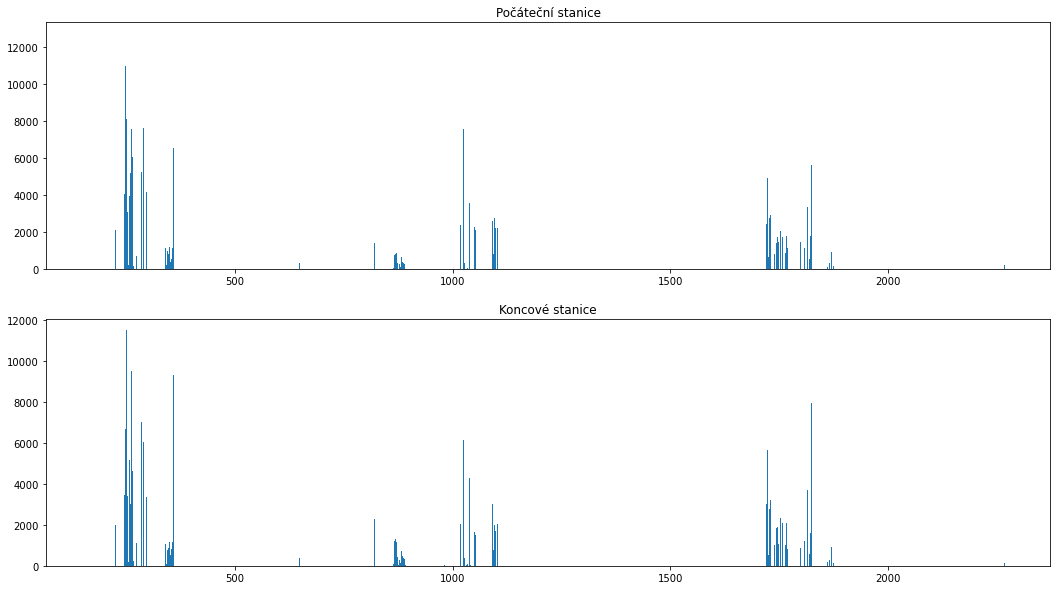

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(18,10))
lowest_id = 171
highest_id = 2268
stations = bikes_df.sort_values("start_station_id").query(f"{lowest_id} <= start_station_id <= {highest_id}")["start_station_id"]
stations2 = bikes_df.sort_values("end_station_id").query(f"{lowest_id} <= end_station_id <= {highest_id}")["end_station_id"]
#(n, bin, patches) = plt.hist(stations,2097)
ax1.hist(stations,bins=highest_id-lowest_id)
ax2.hist(stations2,bins=highest_id-lowest_id)
ax1.set_title("Počáteční stanice")
ax2.set_title("Koncové stanice")
plt.show()


# Obdobný graf s bar grafy, nepřehledná x osa a výpočet trvá mnohem déle - rychlý je pouze když se dá "line" plot
# id_range = bikes_df["start_station_id"].max()
# grouped_starts = bikes_df[["started_at","start_station_id"]].groupby("start_station_id").count()
# grouped_ends = bikes_df[["ended_at","end_station_id"]].groupby("end_station_id").count()
# pd.DataFrame(index=np.arange(1,id_range+1)).join(grouped_starts).plot(kind="bar",figsize=(18,6),ylim=(0,12500))


#### Rozdělení číslovaných stanic podle polohy
- první skupina do 500 oblast centra
- další skupiny odlehlejší lokality + další stanice v centru

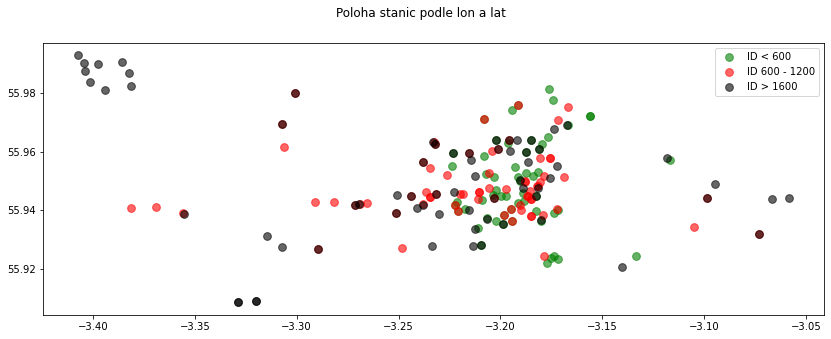

In [6]:
stations1 = bikes_df.drop_duplicates("start_station_id").sort_values("start_station_id").query("100 <= start_station_id <= 600")[["start_station_id", "start_station_latitude","start_station_longitude"]]
stations2 = bikes_df.drop_duplicates("start_station_id").sort_values("start_station_id").query("600 <= start_station_id <= 1200")[["start_station_id", "start_station_latitude","start_station_longitude"]]
stations3 = bikes_df.drop_duplicates("start_station_id").sort_values("start_station_id").query("1600 <= start_station_id <= 2268")[["start_station_id", "start_station_latitude","start_station_longitude"]]

fig, ax = plt.subplots(figsize=(14,5))
ax.scatter(stations1["start_station_longitude"],stations1["start_station_latitude"],c="green", alpha=0.6,s=60)
ax.scatter(stations2["start_station_longitude"],stations2["start_station_latitude"],c="red", alpha=0.6,s=60)
ax.scatter(stations3["start_station_longitude"],stations3["start_station_latitude"],c="black", alpha=0.6,s=60)
plt.suptitle("Poloha stanic podle lon a lat")
plt.legend(["ID < 600","ID 600 - 1200","ID > 1600"]);

In [7]:
stations = bikes_df.drop_duplicates(["start_station_id"]).sort_values("start_station_id")[["start_station_id","start_station_name", "start_station_latitude","start_station_longitude", "start_station_description"]]

fig = px.scatter_mapbox(stations,lat = "start_station_latitude", lon = "start_station_longitude", hover_name="start_station_name",
                        hover_data=["start_station_id","start_station_description" ],color="start_station_id", color_discrete_sequence = ["black"],
                        title = "Mapa stanic kol v Edingburgu podle ID", zoom = 10, range_color=[100,2000],
                                                    color_continuous_scale=[(0.00, "red"),   (0.3, "red"),
                                                     (0.3, "blue"), (0.75, "blue"),
                                                     (0.75, "black"),  (1.00, "black")])
fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(marker=dict(size=16,opacity=0.6,
                              ),
                  selector=dict(mode='markers'))

## Identifikace aktivních a neaktivních stanic
Neaktivní stanice - stanice s méně než průměrně 1 půjčka /den

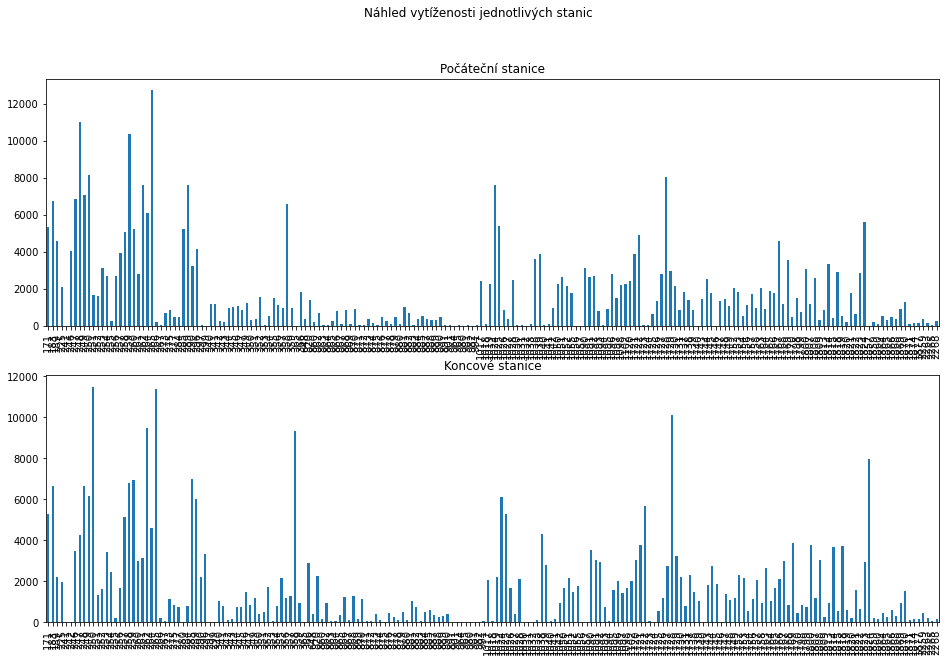

In [8]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(16,10))
ax1 = bikes_df["start_station_id"].value_counts().sort_index().plot(ax=ax1,kind="bar",title="Počáteční stanice")  # rozdělení vytížení odjezdových stanic
ax2 = bikes_df["end_station_id"].value_counts().sort_index().plot(ax=ax2,kind="bar", title="Koncové stanice")  # rozdělení vytížení příjezdových stanic
plt.suptitle("Náhled vytíženosti jednotlivých stanic");

In [9]:
# Seznam stanic a jejich polohy
stations.set_index("start_station_id", inplace=True)
stations.index.rename(name="station_id",inplace=True)
stations

start_station_name  start_station_latitude  \
station_id                                                     
171                    George Square               55.943084   
183                  Waverley Bridge               55.951344   
189                    City Chambers               55.950109   
225                   Waverley Court               55.951734   
241                            Depot               55.972373   
...                              ...                     ...   
1877               Port Edgar Marina               55.992957   
2259                Leith Walk North               55.967918   
2263                Musselburgh Lidl               55.943880   
2265        Musselburgh Brunton Hall               55.944009   
2268                    Picady Place               55.956535   

            start_station_longitude  \
station_id                            
171                       -3.188311   
183                       -3.191421   
189                       -3.190258   
225                       -3.184179   
241                       -3.155833   
...                             ...   
1877                      -3.407156   
2259                      -3.173586   
2263                      -3.066754   
2265                      -3.058493   
2268                      -3.186248   

                                    start_station_description  
station_id                                                     
171         George Square, south side in front of Universi...  
183                            near the top of the South ramp  
189                                  City Chambers Quadrangle  
225                               On Waverley Court forecourt  
241                                                     Depot  
...                                                       ...  
1877                       Next to Marina Shop and Restaurant  
2259                                   Next to Allander House  
2263        Musselborough North High Street opposite Harbo...  
2265                          Adjacent to the Brunton Theatre  
2268                                      Outside Omni Centre  

[198 rows x 4 columns]

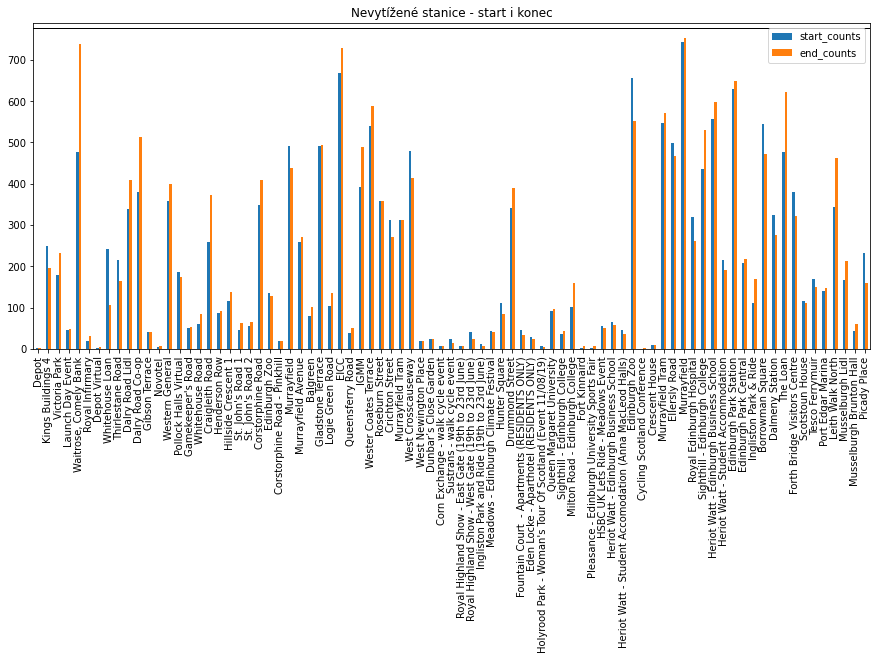

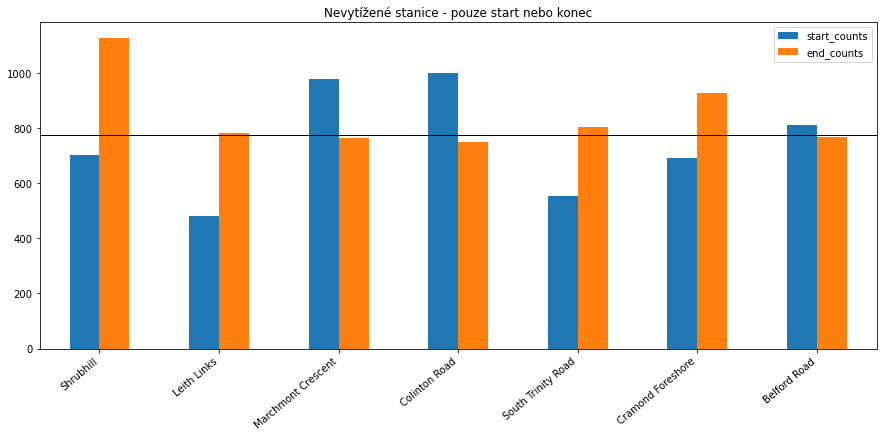

In [10]:
# Neaktivní - nevytížené stanice

num_of_days = (bikes_df["started_at"].max()-bikes_df["started_at"].min()).days  # celkový počet dnů z dodaných dat

start_counts=bikes_df["start_station_id"].value_counts().sort_index()  # počet začátku výpůjčky na dané stanici
end_counts=bikes_df["end_station_id"].value_counts().sort_index()  # počet ukončených výpůjček na dané stanici

# dataframe s počty výpůjček
counts_df = pd.DataFrame(index=stations.index,data={"start_counts":start_counts,"end_counts":end_counts, "difference": start_counts-end_counts})

stations_counts_df = counts_df.join(stations)  # dataframe s počty a názvy a lokace stanic

stations_low_df1 = stations_counts_df[(stations_counts_df["end_counts"]<num_of_days) & (stations_counts_df["start_counts"]<num_of_days)]
stations_low_df2 = stations_counts_df[((stations_counts_df["end_counts"]>num_of_days) & (stations_counts_df["start_counts"]<num_of_days)) | ((stations_counts_df["end_counts"]<num_of_days) & (stations_counts_df["start_counts"]>num_of_days))]
stations_low_df = pd.concat([stations_low_df1,stations_low_df2],axis=0).sort_index()

ax1= stations_low_df1[["start_counts","end_counts","start_station_name"]].plot(kind="bar", x="start_station_name",figsize=(15,6),title="Nevytížené stanice - start i konec")
ax2= stations_low_df2[["start_counts","end_counts","start_station_name"]].plot(kind="bar", x="start_station_name",figsize=(15,6),title="Nevytížené stanice - pouze start nebo konec")

for ax in (ax1,ax2):
    ax.set_xlabel(None)
    ax.axhline(y=num_of_days,color="black", linewidth=1)
plt.setp(ax2.get_xticklabels(), rotation=40, ha='right');

#### Stanice s vysokou aktivitou
Jako hranici jsem zvolil počet půjček větší než je dvojnásobek průměru

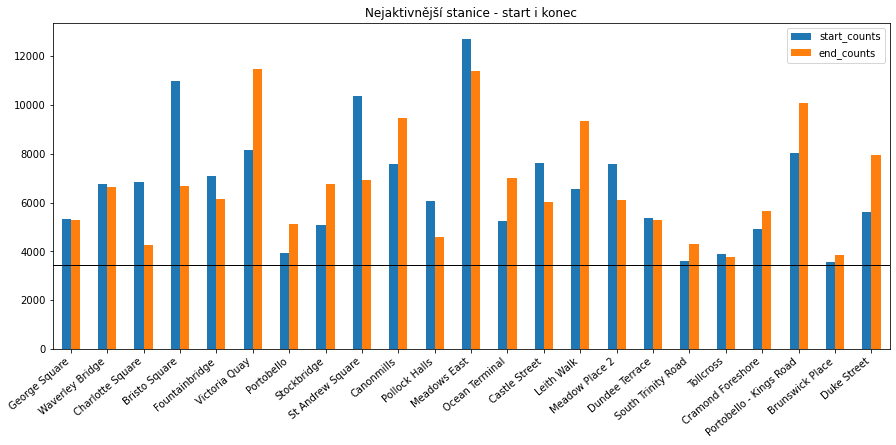

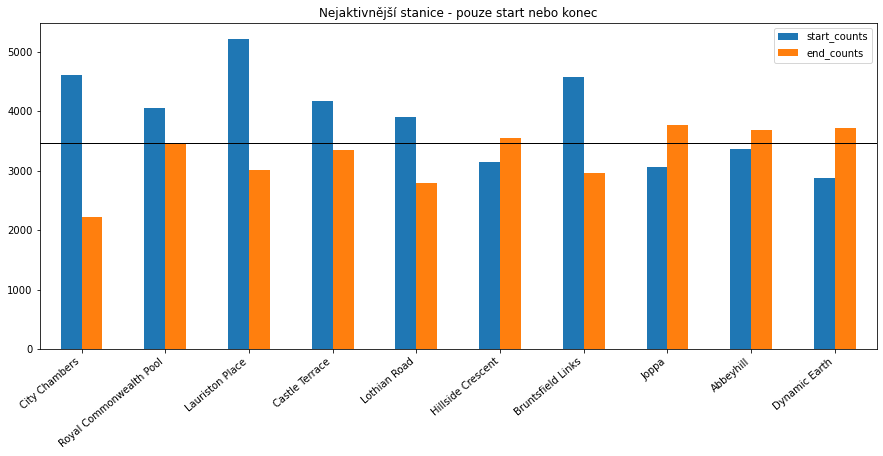

In [11]:
average_total_count = stations_counts_df.end_counts.mean()
limit = average_total_count *2

stations_high_df1 = stations_counts_df[(stations_counts_df["end_counts"]>limit) & (stations_counts_df["start_counts"]>limit)]
stations_high_df2 = stations_counts_df[((stations_counts_df["end_counts"]>limit) & (stations_counts_df["start_counts"]<limit)) | ((stations_counts_df["end_counts"]<limit) & (stations_counts_df["start_counts"]>limit))]
stations_high_df = pd.concat([stations_high_df1,stations_high_df2],axis=0).sort_index()

ax1 = stations_high_df1[["start_counts","end_counts","start_station_name"]].plot(kind="bar", x="start_station_name",figsize=(15,6),title="Nejaktivnější stanice - start i konec")

ax2 = stations_high_df2[["start_counts","end_counts","start_station_name"]].plot(kind="bar", x="start_station_name",figsize=(15,6),title="Nejaktivnější stanice - pouze start nebo konec")
 
for ax in (ax1,ax2):
    ax.set_xlabel(None)
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right')
    ax.axhline(y=limit,color="black", linewidth=1)


## Stanice největším rozdílem mezi výpůjčkami a vracením
Ze seznamu jsem vynechal málo aktivní stanice a zvolil rozdíl nad 30% jejich průměru

In [12]:
stations_diff_df = (stations_counts_df.drop(stations_low_df1.index,axis=0)
    [abs(stations_counts_df["difference"]) > abs((stations_counts_df["start_counts"]+stations_counts_df["end_counts"])/2)*0.3]
                   )
print("Kola by mohla chybět na stanicích:")
display(stations_diff_df[stations_diff_df["difference"]>0])
print("Kola by se mohla hromadit na stanicích:")
stations_diff_df[stations_diff_df["difference"]<0]

Kola by mohla chybět na stanicích:


<ipython-input-12-e4d3801111c2>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



start_counts  end_counts  difference   start_station_name  \
station_id                                                              
189                 4605      2223.0      2382.0        City Chambers   
247                 6834      4248.0      2586.0     Charlotte Square   
248                10999      6672.0      4327.0        Bristo Square   
256                 2717      1657.0      1060.0     St Andrews House   
259                10372      6943.0      3429.0     St Andrew Square   
260                 5218      3014.0      2204.0      Lauriston Place   
290                 3255      2222.0      1033.0          Bruntsfield   
341                 1174       781.0       393.0  Warrender Park Road   
1039                3905      2791.0      1114.0         Lothian Road   
1050                2271      1658.0       613.0                 EICC   
1052                2148      1483.0       665.0        Surgeons Hall   
1096                2791      2008.0       783.0   West Crosscauseway   
1767                4571      2966.0      1605.0    Bruntsfield Links   
1768                1152       823.0       329.0     Thirlestane Road   
1798                1488       858.0       630.0      Chambers Street   

            start_station_latitude  start_station_longitude  \
station_id                                                    
189                      55.950109                -3.190258   
247                      55.952335                -3.207101   
248                      55.946004                -3.188665   
256                      55.953164                -3.181682   
259                      55.954749                -3.192774   
260                      55.944772                -3.197266   
290                      55.937159                -3.206435   
341                      55.938363                -3.198031   
1039                     55.947409                -3.205765   
1050                     55.946071                -3.210396   
1052                     55.946643                -3.185475   
1096                     55.943836                -3.184951   
1767                     55.937123                -3.206432   
1768                     55.935324                -3.198763   
1798                     55.947600                -3.188920   

                                    start_station_description  
station_id                                                     
189                                  City Chambers Quadrangle  
247                          North Corner of Charlotte Square  
248                            Bristo Square, near Potter Row  
256                                      beside Jacobs ladder  
259                                         North East corner  
260                                      near Chalmers Street  
290         Corner of Bruntsfield Terrace and Bruntsfield ...  
341         Corner of Warrender Park Road & Spottiswoode S...  
1039                                   Outside the Usher Hall  
1050        Outside Edinburgh International Conference Centre  
1052                             East side of Nicolson Street  
1096                       On island next to Buccleuch Street  
1767        Corner of Bruntsfield Links next to Public Toi...  
1768                       On corner with St Margaret's Place  
1798                                  Outside National Museum

Kola by se mohla hromadit na stanicích:


start_counts  end_counts  difference  \
station_id                                         
250                 8140     11479.0     -3339.0   
273                  704      1127.0      -423.0   
284                  481       784.0      -303.0   
346                 1086      1499.0      -413.0   
354                  552       803.0      -251.0   
355                 1498      2166.0      -668.0   
358                 6554      9326.0     -2772.0   
366                 1815      2885.0     -1070.0   
820                 1411      2278.0      -867.0   
866                  797      1228.0      -431.0   
868                  840      1303.0      -463.0   
1026                 859      1690.0      -831.0   
1095                 922      1565.0      -643.0   
1824                5617      7961.0     -2344.0   

                        start_station_name  start_station_latitude  \
station_id                                                           
250                          Victoria Quay               55.977638   
273                              Shrubhill               55.962537   
284                            Leith Links               55.969199   
346                       Morningside Road               55.927986   
354                     South Trinity Road               55.971269   
355                         Inverleith Row               55.964146   
358                             Leith Walk               55.965040   
366         Newhaven Road / Dudley Gardens               55.975927   
820                            Newkirkgate               55.970704   
866                       Comely Bank Road               55.959407   
868                          Dundas Street               55.960944   
1026                   Constitution Street               55.975441   
1095                        Dudley Gardens               55.975940   
1824                           Duke Street               55.969012   

            start_station_longitude  \
station_id                            
250                       -3.174116   
273                       -3.179473   
284                       -3.166885   
346                       -3.209739   
354                       -3.207816   
355                       -3.202074   
358                       -3.176686   
366                       -3.191318   
820                       -3.171624   
866                       -3.215660   
868                       -3.201387   
1026                      -3.166806   
1095                      -3.191321   
1824                      -3.167395   

                                    start_station_description  
station_id                                                     
250                    Entrance to Scottish Government Office  
273                                    Sainsbury's Leith Walk  
284                 Corner of Vanburgh Place and Lochend Road  
346         Corner of Morningside Road & Morningside Park ...  
354                 Corner of South Trinity Road & Ferry Road  
355             Corner of Inverleith Row & Inverleith Terrace  
358                        Leith Walk opposite Dalmeny Street  
366                 Corner of Dudley Gardens on Newhaven Road  
820         19 point docking station beside queen victoria...  
866                         Between trees on Comely Bank Road  
868                   Corner of Dundas Street & Henderson Row  
1026                                     Next to Burns Statue  
1095                  Opposite Victoria Park on Newhaven Road  
1824                                Junction with Easter Road

## Mapa - aktivní a neaktivní stanice
Nejaktivnější jsou stanice v centru, nejméně aktivní ty vzdálené  
Protože je to počítáno z celkových dat, je pravděpodobné že stanice s vysokými čísly, která jsou většinou mimo centrum byly zavedeny o něco později a proto může být počet výpůjček nižší, zvlášť pokud by nějaké byly vytvořeny až ke konci analyzovaného období. Stejně tak jsou mezi nimi i stanice, které existovali jen chvíli, např. kvůli nějakému "eventu" a pak byly zas zrušeny.  <p>
Pro lepší porovnání by bylo dobré vztáhnout počty výpůjček na dobu po kterou jsou jednotlivé stanice v provozu.

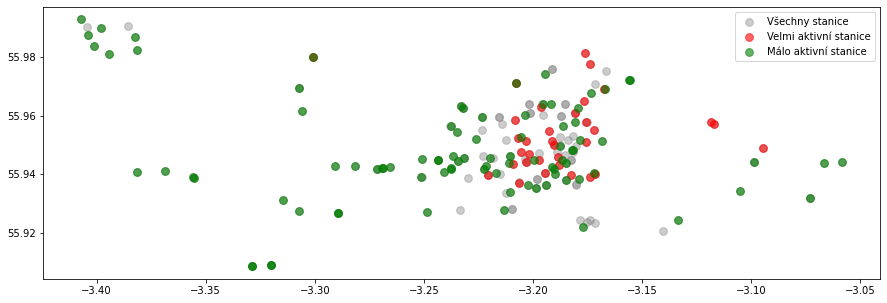

In [13]:

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(stations_counts_df["start_station_longitude"],stations_counts_df["start_station_latitude"],c="grey", alpha=0.4,s=60)
ax.scatter(stations_high_df["start_station_longitude"],stations_high_df["start_station_latitude"],c="red", alpha=0.6,s=60)
ax.scatter(stations_low_df["start_station_longitude"],stations_low_df["start_station_latitude"],c="green", alpha=0.6,s=60)
plt.legend(["Všechny stanice","Velmi aktivní stanice","Málo aktivní stanice"]);

## Mapa - nerovnoměrně vytížené stanice
Při zobrazení stanic s největšími rozdíly je vidět, že v centru kola chybí (diff > 0) a naopak směrem k moři kola spíše přebývají.
Podobně je to vidět i v mapě s nejaktivnějšími stanicemi.

In [14]:
fig = px.scatter_mapbox(stations_diff_df,lat = "start_station_latitude", lon = "start_station_longitude", hover_name="start_station_name",
                        hover_data=["start_station_name","start_station_description" ],color="difference", color_discrete_sequence = ["black"],
                        title = "Stanice s největšími rozdíly mezi počtem výpůjčení - vrácení", zoom = 10
                                                    )
fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(marker=dict(size=16,opacity=0.6,
                              ),
                  selector=dict(mode='markers'))

In [15]:
fig = px.scatter_mapbox(stations_high_df,lat = "start_station_latitude", lon = "start_station_longitude", hover_name="start_station_name",
                        hover_data=["start_station_name","start_station_description" ],color="difference",
                        title = "Nejaktivnější stanice s rozdíly mezi počtem výpůjčení - vrácení", zoom = 10
                                                    )
fig.update_layout(mapbox_style="open-street-map")
fig.update_traces(marker=dict(size=16,opacity=0.6,
                              ),
                  selector=dict(mode='markers'))

## Vzdálenosti mezi stanicemi

In [16]:
# výpočet vzálenosti dvou bodů v km
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    R = 6371
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2*R * asin(sqrt(a))

In [17]:
# Vzdálenost dvou stanic podle ID v metrech
def distance2(id1,id2):
    lat1 = stations.loc[id1,"start_station_latitude"]
    lon1 = stations.loc[id1,"start_station_longitude"]
    lat2 = stations.loc[id2,"start_station_latitude"]
    lon2 = stations.loc[id2,"start_station_longitude"]
    return round(distance(lat1,lon1,lat2,lon2)*1000)

distance2(1871,1866)    
    

1002

In [44]:
print("Výpočet matice vzdáleností v metrech")
matrix=[]
for i, id1 in enumerate(stations.index):
    matrix.append([])
    for id2 in stations.index:
        matrix[i].append(distance2(id1,id2))
matrix=np.array(matrix)
matrix

Výpočet matice vzdáleností v metrech


array([[   0,  939,  791, ..., 7570, 8084, 1501],
       [ 939,    0,  155, ..., 7806, 8317,  661],
       [ 791,  155,    0, ..., 7721, 8232,  757],
       ...,
       [7570, 7806, 7721, ...,    0,  515, 7572],
       [8084, 8317, 8232, ...,  515,    0, 8075],
       [1501,  661,  757, ..., 7572, 8075,    0]])

#### Vzdálenosti pomocí "scipy" v km - výpočet matice a převedení na DataFrame

In [19]:
def distance3(u, v):
    lat1 = u[0]
    lon1 = u[1]
    lat2 = v[0]
    lon2 = v[1]
    R = 6371
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2*R * asin(sqrt(a))


# scipy výpočet
distances = pdist(stations[["start_station_latitude","start_station_longitude"]].values, metric=distance3)
dist_matrix=squareform(distances)
dist_matrix

pd.DataFrame(dist_matrix, columns=[f'{name}, {stations.loc[name,"start_station_name"]}' for name in stations.index], index=[f'{name}, {stations.loc[name,"start_station_name"]}' for name in stations.index])


171, George Square  183, Waverley Bridge  \
171, George Square                        0.000000              0.938697   
183, Waverley Bridge                      0.938697              0.000000   
189, City Chambers                        0.790522              0.155259   
225, Waverley Court                       0.995705              0.452978   
241, Depot                                3.833268              3.220862   
...                                            ...                   ...   
1877, Port Edgar Marina                  14.704725             14.199040   
2259, Leith Walk North                    2.909576              2.151431   
2263, Musselburgh Lidl                    7.569919              7.806475   
2265, Musselburgh Brunton Hall            8.084481              8.316695   
2268, Picady Place                        1.501210              0.660968   

                                189, City Chambers  225, Waverley Court  \
171, George Square                        0.790522             0.995705   
183, Waverley Bridge                      0.155259             0.452978   
189, City Chambers                        0.000000             0.419411   
225, Waverley Court                       0.419411             0.000000   
241, Depot                                3.274098             2.894683   
...                                            ...                  ...   
1877, Port Edgar Marina                  14.312821            14.612102   
2259, Leith Walk North                    2.235671             1.916506   
2263, Musselburgh Lidl                    7.721055             7.363227   
2265, Musselburgh Brunton Hall            8.232298             7.872627   
2268, Picady Place                        0.756886             0.549139   

                                241, Depot  246, Royal Commonwealth Pool  \
171, George Square                3.833268                      1.004476   
183, Waverley Bridge              3.220862                      1.752459   
189, City Chambers                3.274098                      1.600128   
225, Waverley Court               2.894683                      1.553305   
241, Depot                        0.000000                      3.878020   
...                                    ...                           ...   
1877, Port Edgar Marina          15.800775                     15.706140   
2259, Leith Walk North            1.210723                      3.215584   
2263, Musselburgh Lidl            6.386218                      6.695863   
2265, Musselburgh Brunton Hall    6.830851                      7.209836   
2268, Picady Place                2.585448                      2.095361   

                                247, Charlotte Square  248, Bristo Square  \
171, George Square                           1.557882            0.325452   
183, Waverley Bridge                         0.982399            0.618092   
189, City Chambers                           1.077454            0.467113   
225, Waverley Court                          1.428648            0.695733   
241, Depot                                   3.891838            3.574040   
...                                               ...                 ...   
1877, Port Edgar Marina                     13.242279           14.564298   
2259, Leith Walk North                       2.711830            2.611254   
2263, Musselburgh Lidl                       8.788854            7.594858   
2265, Musselburgh Brunton Hall               9.298992            8.108627   
2268, Picady Place                           1.379631            1.180635   

                                249, Fountainbridge  250, Victoria Quay  ...  \
171, George Square                         1.304080            3.942485  ...   
183, Waverley Bridge                       1.421559            3.115760  ...   
189, City Chambers                         1.400648            3.221676  ...   
225, Waverley Court                        1.817731         

# Clustering stanic
- pro případné další analýzy
- pro výpočet matice vzdáleností tentokrát použit sklearn, ale funguje stejně jako scipy

### Nejdříve jsem zkoušel KMeans
- podle hokejkového grafu nebo Silhouette koeficientu se pokusil odhladnout vhodný počet clustrů
- nejlépe asi vycházel kolem cca 15-20 clustrů, ale závisí na použitém "random_state"

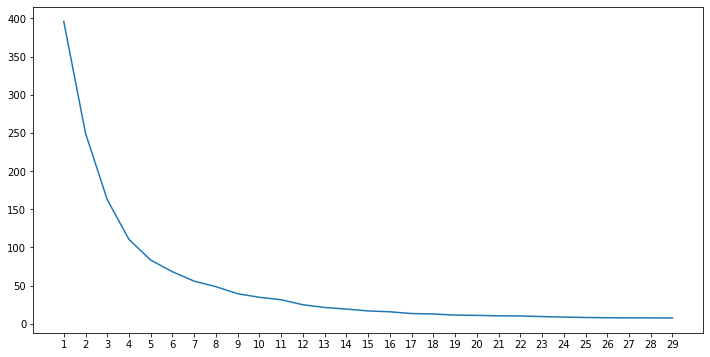

In [45]:
# normalizace dat
scaler = StandardScaler()
stations1 = bikes_df.drop_duplicates("start_station_id").sort_values("start_station_id")[["start_station_id", "start_station_latitude","start_station_longitude"]]
scaled_stations1 = scaler.fit_transform(stations1.drop("start_station_id",axis=1))
scaled_stations1

# parametry
kmeans_kwargs = {"init":"random", "n_init":15, "max_iter": 300, "random_state": 2}

sse = []
for nc in range(1,30):
    kmeans = KMeans(n_clusters= nc,  **kmeans_kwargs)
    kmeans.fit(scaled_stations1)
    sse.append(kmeans.inertia_)

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(range(1,30), sse)
plt.xticks(range(1,30))
plt.show()


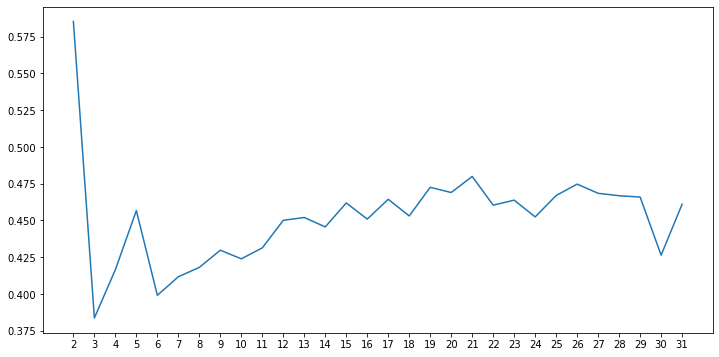

In [46]:
silhouette_coef = []
for nc in range(2,32):
    kmeans = KMeans(n_clusters= nc,  **kmeans_kwargs)
    kmeans.fit(scaled_stations1)
    score = silhouette_score(scaled_stations1, kmeans.labels_)
    silhouette_coef.append(score)

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(range(2,32), silhouette_coef)
plt.xticks(range(2,32))
plt.show()

Počet clustrů KMeans model: 21


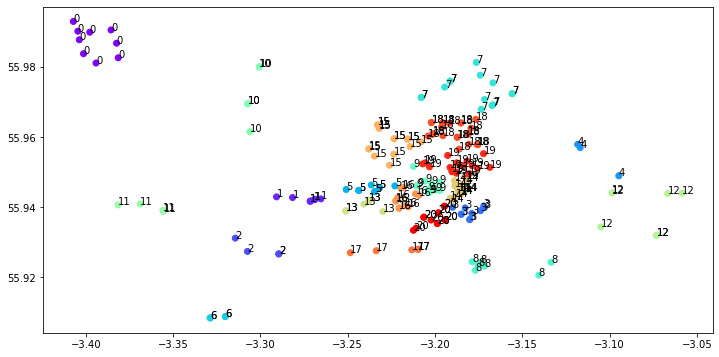

In [47]:
kmeans = KMeans(n_clusters= 21,  **kmeans_kwargs)
kmeans.fit(scaled_stations1)
print("Počet clustrů KMeans model: 21") 

fig,ax = plt.subplots(figsize=(12,6))
ax.scatter(pd.DataFrame(scaler.inverse_transform(scaled_stations1))[1],pd.DataFrame(scaler.inverse_transform(scaled_stations1))[0],c=kmeans.labels_, cmap='rainbow')

for i, cluster in enumerate(kmeans.labels_):
    ax.text(stations1.iloc[i,2], stations1.iloc[i,1], cluster)

## Aglomerativní clustering
### O něco lepší mi přijde aglomerativní clustering, bez normalizace s výpočtem vzáleností přímo z lon a lat


In [ ]:
def count_affinity(X):
    return pairwise_distances(X, metric=distance3)

X = stations[["start_station_latitude","start_station_longitude"]]

#### Základní skupiny stanic jsou cca 4 km od sebe vzdálené, nejvíce stanic v širším centru
#### Pro jemněší rozdělení zvolena vzdálenost 1,5 km

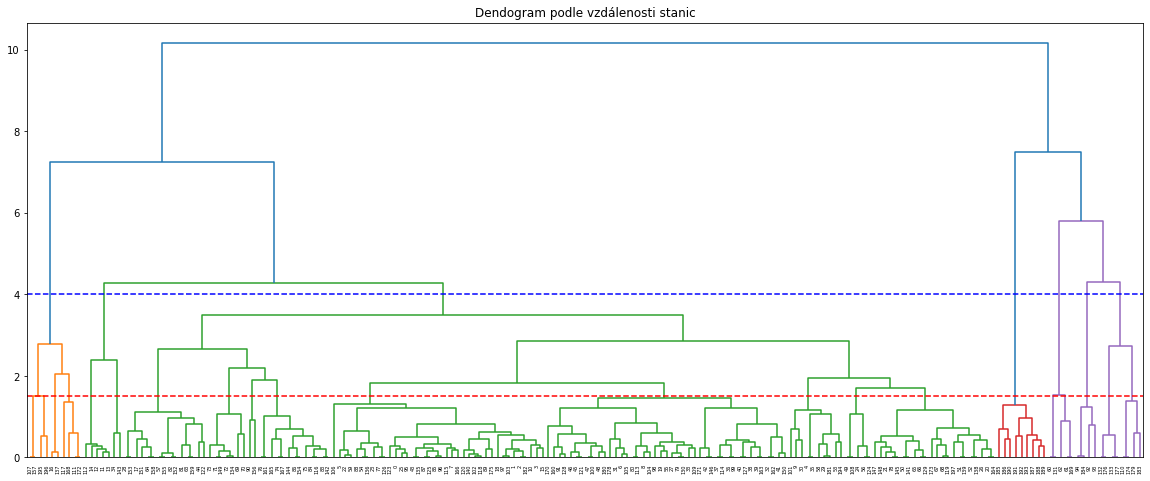

In [58]:
plt.figure(figsize=(20, 8))
plt.title("Dendogram podle vzdálenosti stanic")
dend = shc.dendrogram(shc.linkage(X, method="average", metric=distance3))
plt.axhline(y=4, color='b', linestyle='--')
plt.axhline(y=1.5, color='r', linestyle='--');

Počet clustrů pro "average threshold" 4 km:  7


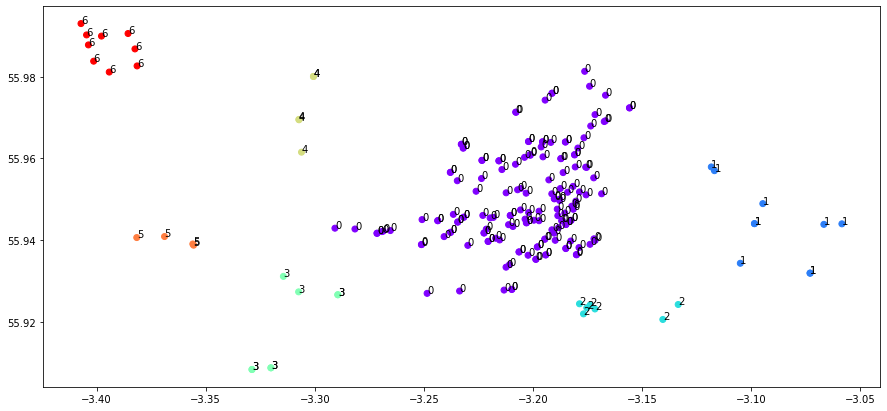

In [61]:
model = AgglomerativeClustering(n_clusters=None,
                                    linkage="average",distance_threshold=4, affinity=count_affinity)
model.fit_predict(X)
print('Počet clustrů pro "average threshold" 4 km: ', len(set(model.labels_)) )

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X.iloc[:,1], X.iloc[:,0], c=model.labels_, cmap='rainbow')

for i, cluster in enumerate(model.labels_):
    ax.text(stations.iloc[i,2], stations.iloc[i,1], cluster)

Počet clustrů pro "average threshold" 1,5 km:  21


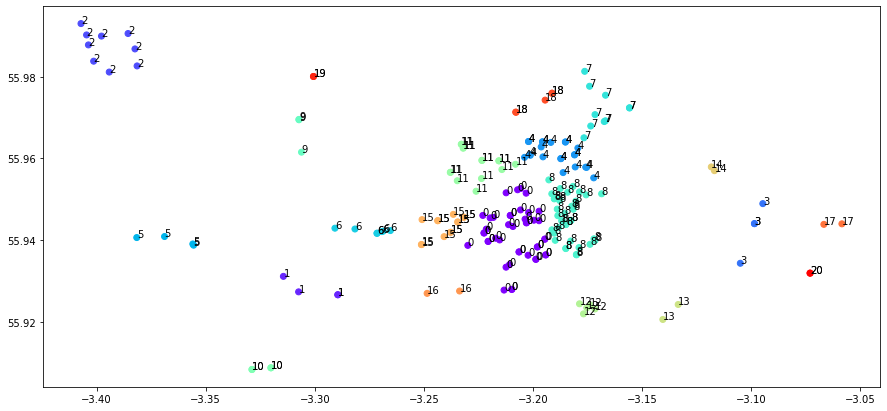

In [57]:
model = AgglomerativeClustering(n_clusters=None,
                                    linkage="average",distance_threshold=1.5, affinity=count_affinity)
model.fit_predict(X)
print('Počet clustrů pro "average threshold" 1,5 km: ', len(set(model.labels_)) )

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X.iloc[:,1], X.iloc[:,0], c=model.labels_, cmap='rainbow')

for i, cluster in enumerate(model.labels_):
    ax.text(stations.iloc[i,2], stations.iloc[i,1], cluster)

## Závěr
- Lepší klastrování by asi byla kombinace - Největší skupinu 0 (širší centrum) ze základních 7mi skupin clusterovat samostatně na menší skupiny (např. 200-500 metrů vzdálenost). Je zde hodně stanic i větší počty výpůjček
- Klastrovaná data by se mohli znovu zanalyzovat ohledně počtů výpůjček, vytížení a potenciálních chybějících-přebývajících kol
- Další varianty by byly porovnání vytížení stanic ve všední dny a o víkendu, popř. v nějakých kratších časových usecích než celý rozsah měřených dat